<a href="https://colab.research.google.com/github/RahalJay/Loan_AApproval_Prediction_Kaggle_Competition/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loan Approval Prediction

In [52]:
!pip install numpy pandas scikit-learn tensorflow keras matplotlib seaborn flask
!pip install catboost

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split

Encoding Categorical Features and Saving Preprocessed Data

In [54]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Load train and test datasets
train_df, test_df = (pd.read_csv(f, encoding="utf-8") for f in ["train.csv", "test.csv"])

# Define categorical columns
categorical_columns = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Encode categorical columns and store label encoders
label_encoders = {col: LabelEncoder().fit(train_df[col].astype(str)) for col in categorical_columns}

# Apply encoding to train and test data
train_df.update(train_df[categorical_columns].apply(lambda col: label_encoders[col.name].transform(col.astype(str))))
test_df.update(test_df[categorical_columns].apply(lambda col: label_encoders[col.name].transform(col.astype(str))))

# Save encoded data
train_df.to_csv("train_encoded.csv", index=False)
test_df.to_csv("test_encoded.csv", index=False)

# Save the label encoders
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [4]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


In [55]:
print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)

Train Dataset Shape: (58645, 13)
Test Dataset Shape: (39098, 12)


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [57]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


Find common and uncommon columns

In [58]:
common_columns = train_df.columns.intersection(test_df.columns)
uncommon_columns = train_df.columns.symmetric_difference(test_df.columns)

print(f"Common Columns: {set(common_columns)}\n")
print(f"Uncommon Columns: {set(uncommon_columns)}\n")

Common Columns: {'person_emp_length', 'cb_person_default_on_file', 'id', 'person_income', 'person_home_ownership', 'cb_person_cred_hist_length', 'loan_int_rate', 'loan_grade', 'loan_percent_income', 'loan_amnt', 'loan_intent', 'person_age'}

Uncommon Columns: {'loan_status'}



In [59]:
train_df.loan_status.value_counts()

,count
loan_status,
0,50295
1,8350


Visualization of Loan Status Distribution

<ipython-input-60-ffc6749317ed>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="coolwarm")


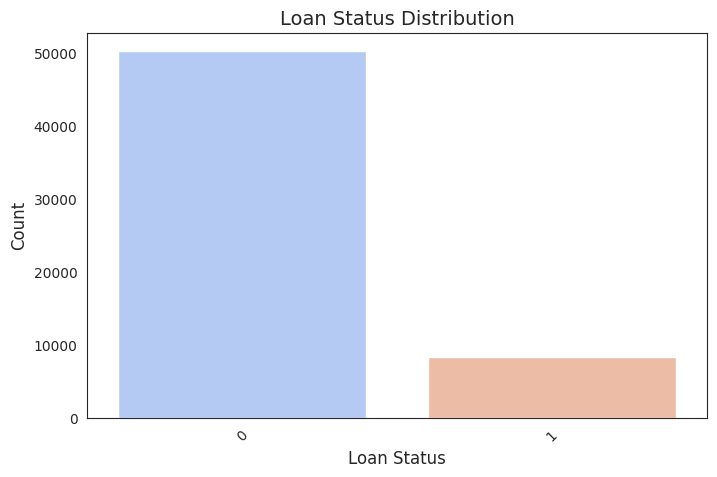

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the count of each category in "loan_status"
loan_status_counts = train_df["loan_status"].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="coolwarm")

# Add labels and a title
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Loan Status Distribution", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Visualizing Categorical Feature Distributions by Loan Status

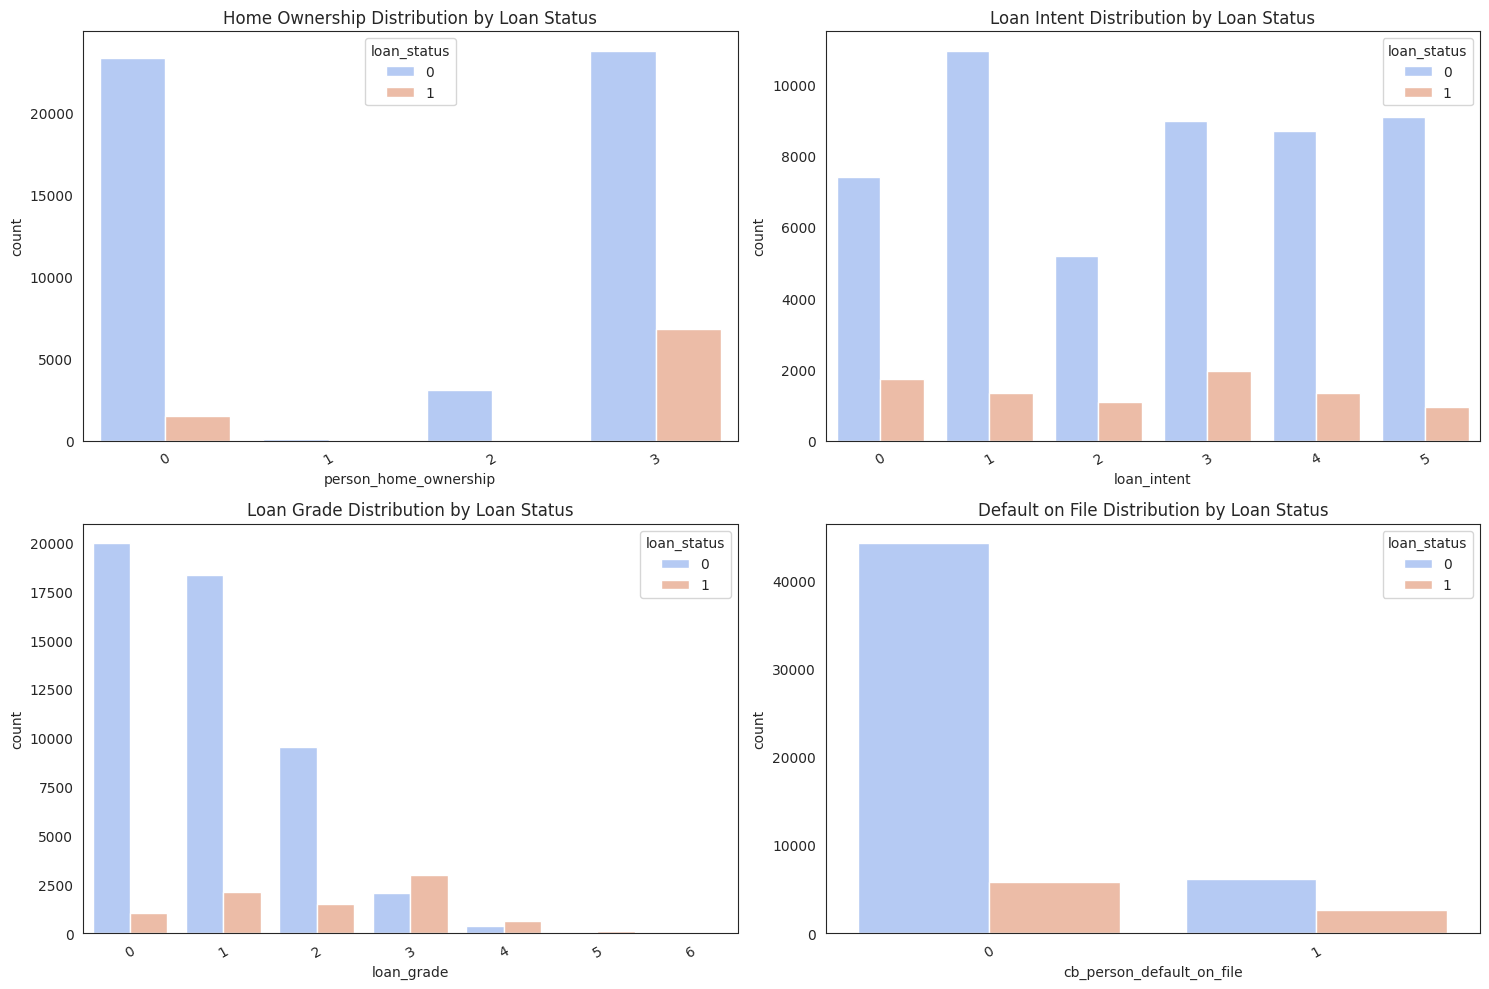

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the categorical features to visualize
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Set figure size
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define a new color palette
custom_palette = "coolwarm"

# Iterate over the categorical features and create count plots
for ax, feature in zip(axes.flatten(), categorical_features):
    sns.countplot(data=train_df, x=feature, hue="loan_status", palette=custom_palette, ax=ax)

    # Customize titles for each graph
    if feature == "person_home_ownership":
        ax.set_title("Home Ownership Distribution by Loan Status")
    elif feature == "loan_intent":
        ax.set_title("Loan Intent Distribution by Loan Status")
    elif feature == "loan_grade":
        ax.set_title("Loan Grade Distribution by Loan Status")
    elif feature == "cb_person_default_on_file":
        ax.set_title("Default on File Distribution by Loan Status")

    ax.tick_params(axis='x', rotation=30)

# Optimize layout for better spacing
plt.tight_layout()
plt.show()

Visualizing Missing Values in train_df and test_df Using Heatmaps

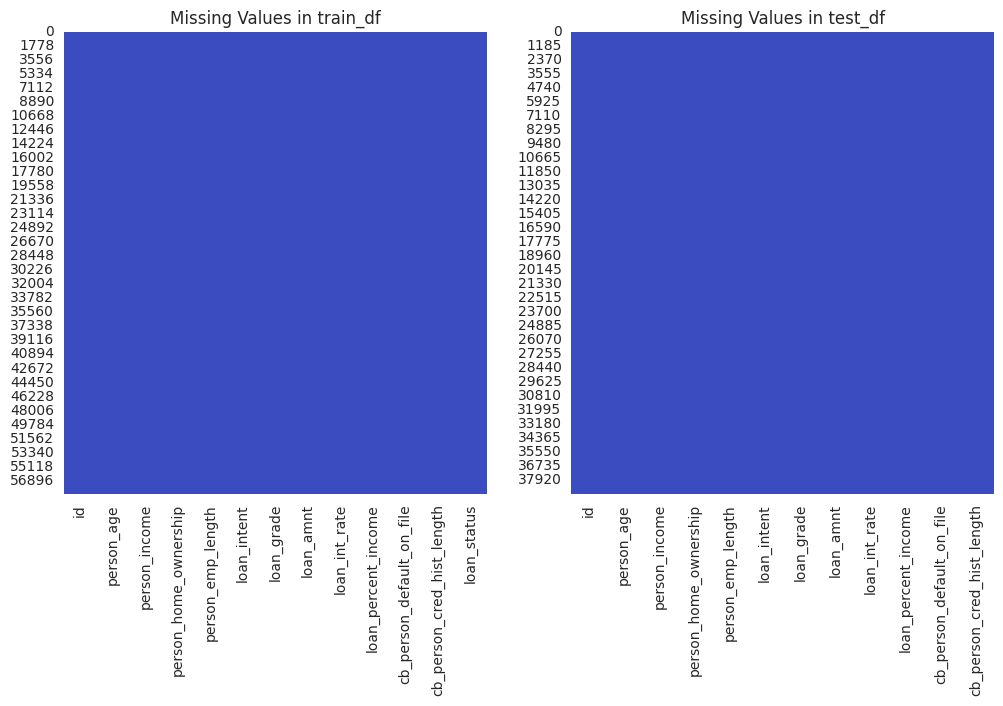

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 1x2 grid for subplots with a size of 12x6
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot missing values for train_df with a different color palette
sns.heatmap(train_df.isnull(), ax=axes[0], cbar=False, cmap='coolwarm')
axes[0].set_title("Missing Values in train_df")

# Plot missing values for test_df with the same color palette
sns.heatmap(test_df.isnull(), ax=axes[1], cbar=False, cmap='coolwarm')
axes[1].set_title("Missing Values in test_df")

# Display the plots
plt.show()

In [63]:
print(f"Number of duplicate values in Train dataset: {train_df.duplicated().sum()}")
print(f"Number of duplicate values in Test dataset: {test_df.duplicated().sum()}")

Number of duplicate values in Train dataset: 0
Number of duplicate values in Test dataset: 0


In [64]:
train_df['person_home_ownership'].unique()

array([3, 2, 0, 1], dtype=object)

Bar Plot of Home Ownership Categories

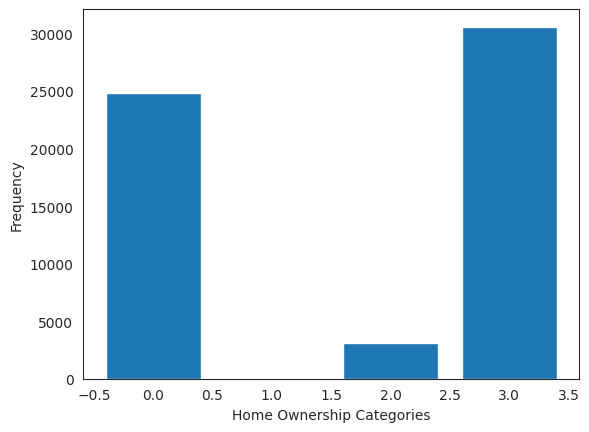

In [65]:
import matplotlib.pyplot as plt

# Retrieve unique values from 'person_home_ownership'
unique_values = train_df['person_home_ownership'].value_counts()

# Display the unique values as a bar plot
plt.bar(unique_values.index, unique_values.values)

# Label the axes
plt.xlabel('Home Ownership Categories')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [66]:
train_df['loan_intent'].unique()

array([1, 3, 4, 5, 0, 2], dtype=object)

Visualizing Frequency of Loan Intent Categories

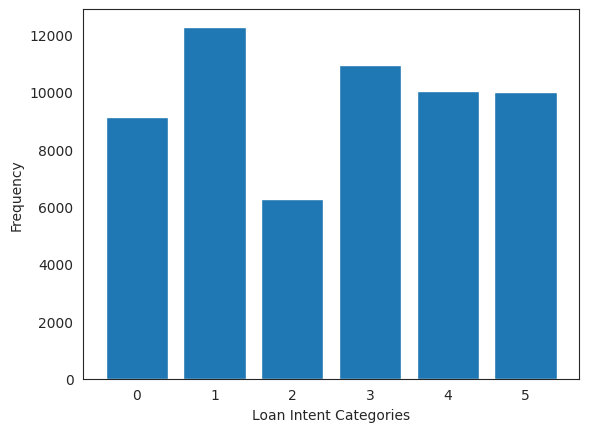

In [67]:
import matplotlib.pyplot as plt

# Retrieve unique values from 'loan_intent'
unique_values = train_df['loan_intent'].value_counts()

# Display the unique values as a bar plot
plt.bar(unique_values.index, unique_values.values)

# Label the axes
plt.xlabel('Loan Intent Categories')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [68]:
train_df['loan_grade'].unique()

array([1, 2, 0, 3, 4, 5, 6], dtype=object)

Visualizing Loan Grade Distribution with a Bar Plot

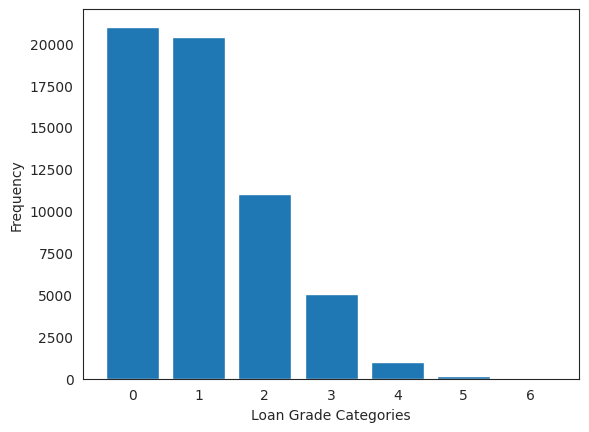

In [69]:
import matplotlib.pyplot as plt

# Retrieve unique values from 'loan_grade'
unique_values = train_df['loan_grade'].value_counts()

# Display the unique values as a bar plot
plt.bar(unique_values.index, unique_values.values)

# Label the axes
plt.xlabel('Loan Grade Categories')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [70]:
train_df['cb_person_default_on_file'].unique()

array([0, 1], dtype=object)

Bar Plot of Default on File Categories

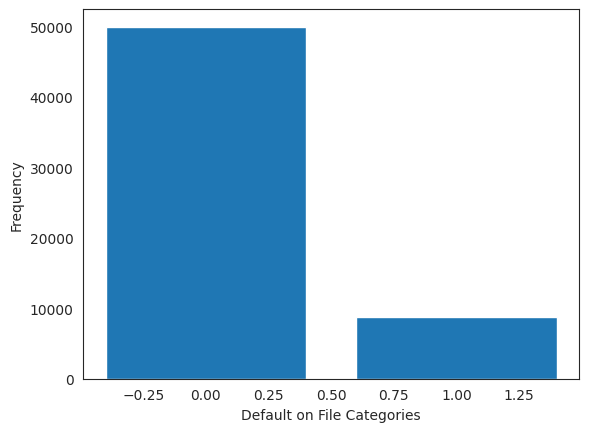

In [71]:
import matplotlib.pyplot as plt

# Retrieve unique values from 'cb_person_default_on_file'
unique_values = train_df['cb_person_default_on_file'].value_counts()

# Display the unique values as a bar plot
plt.bar(unique_values.index, unique_values.values)

# Label the axes
plt.xlabel('Default on File Categories')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [72]:
df = train_df.copy()

In [73]:
# Separate features (X) and target (y)
X, y = df.loc[:, df.columns != "loan_status"], df["loan_status"]

Encoding Categorical Features Using OrdinalEncoder

In [74]:
from sklearn.preprocessing import OrdinalEncoder

# List of categorical features to encode
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Apply transformation to categorical features
X.loc[:, categorical_features] = encoder.fit_transform(X[categorical_features].values)

Feature Selection - Computing Mutual Information for Feature Ranking

In [75]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Compute Mutual Information
mutual_info_values = mutual_info_classif(X, y, random_state=42)

# Create a sorted DataFrame of mutual information values
mutual_info_df = pd.DataFrame({
    'Mutual Information': mutual_info_values
}, index=X.columns).sort_values(by='Mutual Information', ascending=False)

# Display the results
print(mutual_info_df)

                            Mutual Information
person_income                         0.099013
loan_percent_income                   0.081107
loan_grade                            0.081019
loan_int_rate                         0.079717
person_home_ownership                 0.037772
loan_amnt                             0.017547
cb_person_default_on_file             0.014998
loan_intent                           0.009338
person_emp_length                     0.008439
person_age                            0.004770
id                                    0.000000
cb_person_cred_hist_length            0.000000


Visualizing Feature Importance Using Mutual Information

<ipython-input-76-415f08ddf7a9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y=mutual_info_df.index, data=mutual_info_df, palette="viridis", ax=ax)


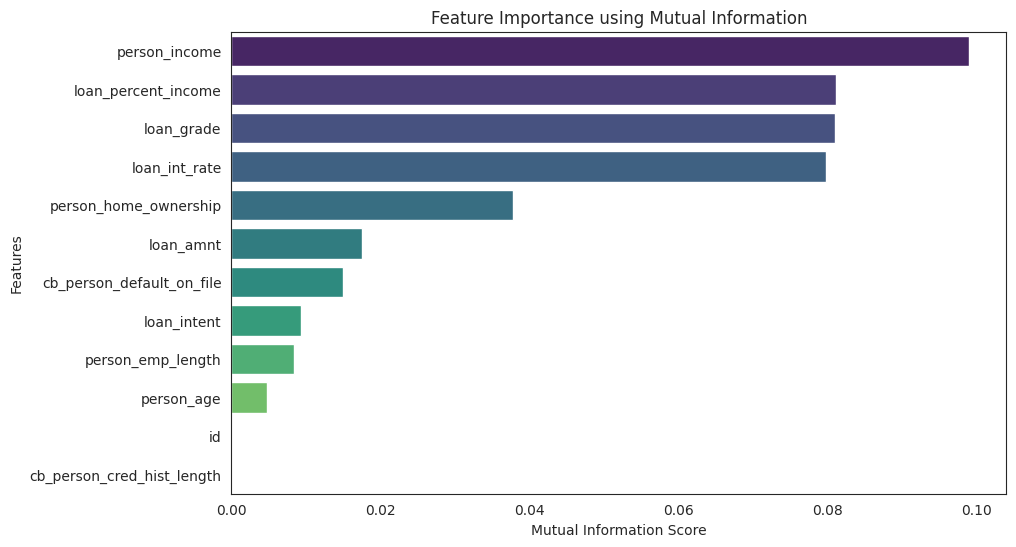

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot with a specified figure size
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='Mutual Information', y=mutual_info_df.index, data=mutual_info_df, palette="viridis", ax=ax)

# Set the axis labels and title
ax.set_xlabel("Mutual Information Score")
ax.set_ylabel("Features")
ax.set_title("Feature Importance using Mutual Information")

# Display the plot
plt.show()

Box Plot visualization

<ipython-input-77-c343069fd735>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y='loan_amnt', data=train_df, palette='coolwarm')


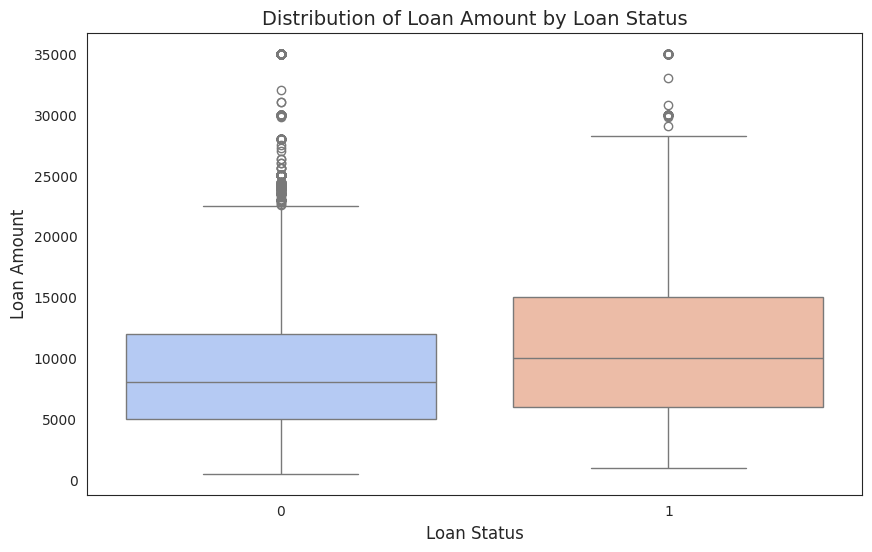

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot to visualize the distribution of 'loan_amnt' by 'loan_status'
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=train_df, palette='coolwarm')

# Set plot labels and title
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12)
plt.title('Distribution of Loan Amount by Loan Status', fontsize=14)

# Show the plot
plt.show()

Correlation Heatmap Visualization of Dataset Features

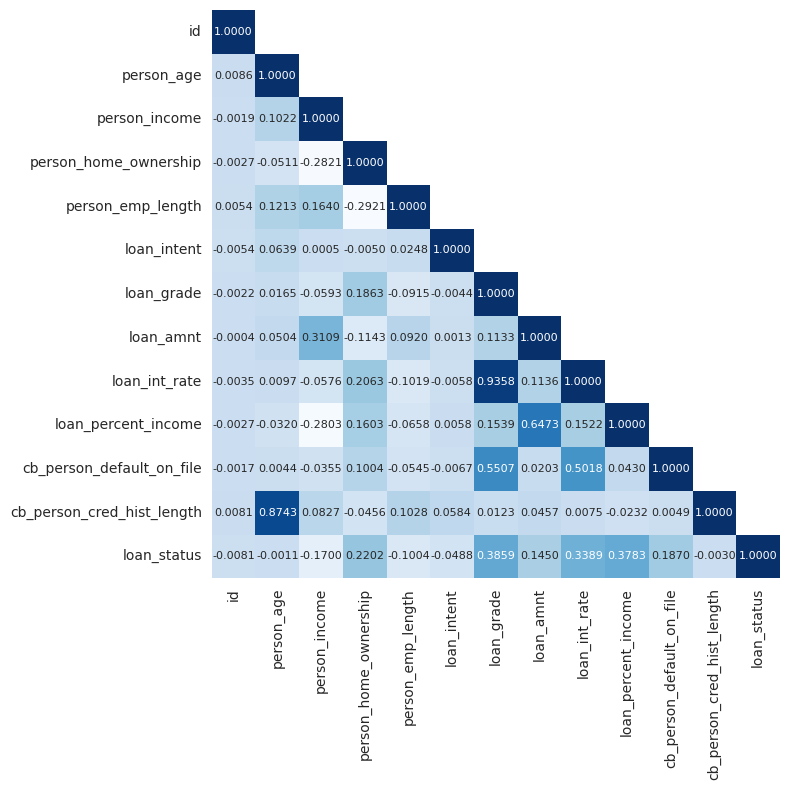

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set the Seaborn style
sns.set_style("white")

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# Calculate the correlation matrix
corr_matrix = pd.concat([X, y], axis=1).corr()

# Create a mask for the upper triangle of the correlation matrix
upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Plot the heatmap with the new color palette
sns.heatmap(
    data=corr_matrix,
    annot=True,
    fmt='.4f',
    mask=upper_triangle_mask,
    square=True,
    cmap='Blues',
    annot_kws={'size': 8},
    cbar=False,
    ax=ax
)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Label Encoding for Categorical Data in Train and Test Datasets

In [79]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(train_df, test_df, categorical_features):
    """
    Encodes categorical columns in the train and test DataFrames using Label Encoding.

    Args:
        train_df (pd.DataFrame): The training dataset.
        test_df (pd.DataFrame): The testing dataset.
        categorical_features (list): List of categorical column names.

    Returns:
        pd.DataFrame, pd.DataFrame: The updated train and test DataFrames.
    """
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        train_df[feature] = le.fit_transform(train_df[feature])
        test_df[feature] = le.transform(test_df[feature])
        label_encoders[feature] = le

    return train_df, test_df

Categorical Feature Encoding and Label Encoder Serialization

In [80]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

# Function to encode categorical features
def prepare(train_df, test_df, categorical_features):
    label_encoders = {}

    for feature in categorical_features:
        encoder = LabelEncoder()

        # Fit the encoder on the training data and transform
        train_df[feature] = encoder.fit_transform(train_df[feature].astype(str))

        # Transform the test data with the same encoder
        test_df[feature] = encoder.transform(test_df[feature].astype(str))

        # Save the encoder for future use
        label_encoders[feature] = encoder

    # Save the label encoders to a file
    joblib.dump(label_encoders, 'label_encoders.pkl')

    return train_df, test_df

# Load train and test datasets
train_df = pd.read_csv('train.csv', encoding='utf-8')
test_df = pd.read_csv('test.csv', encoding='utf-8')

# Specify categorical features
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

# Apply the encoding through the prepare function
train_df, test_df = prepare(train_df, test_df, categorical_features)

# Save the encoded data
train_df.to_csv('train_encoded.csv', index=False)
test_df.to_csv('test_encoded.csv', index=False)

In [81]:
# Separate features and label in a different style
features = train_df.loc[:, train_df.columns != "loan_status"]
label = train_df["loan_status"]

In [82]:
features.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3


In [83]:
label.head()

,loan_status
0,0
1,0
2,0
3,0
4,0


In [84]:
from sklearn.model_selection import train_test_split

# Perform the split operation
split_data = train_test_split(features, label, test_size=0.2, random_state=40)

# Unpack the split data into variables
X_train, X_test, y_train, y_test = split_data[0], split_data[1], split_data[2], split_data[3]

Import Required Libraries

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

Initializing Models

In [86]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42)
}

Training and Evaluating Models

In [87]:
results = {}


----------------------------------------
Random Forest Evaluation Results:
----------------------------------------
Accuracy: 95.10%
R² Score: 0.5907

Confusion Matrix for Random Forest:


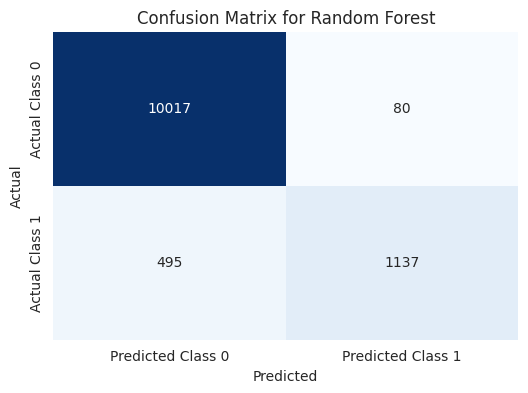

----------------------------------------


----------------------------------------
Gradient Boosting Evaluation Results:
----------------------------------------
Accuracy: 94.82%
R² Score: 0.5679

Confusion Matrix for Gradient Boosting:


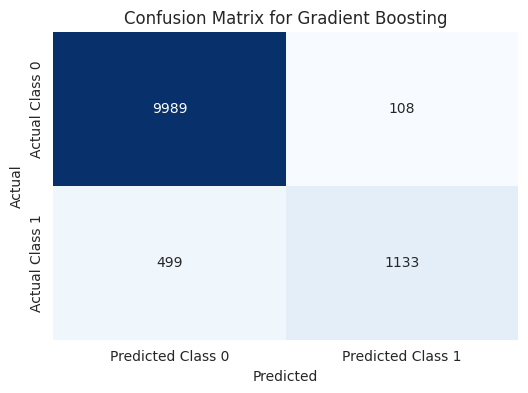

----------------------------------------


----------------------------------------
KNN Evaluation Results:
----------------------------------------
Accuracy: 87.87%
R² Score: -0.0129

Confusion Matrix for KNN:


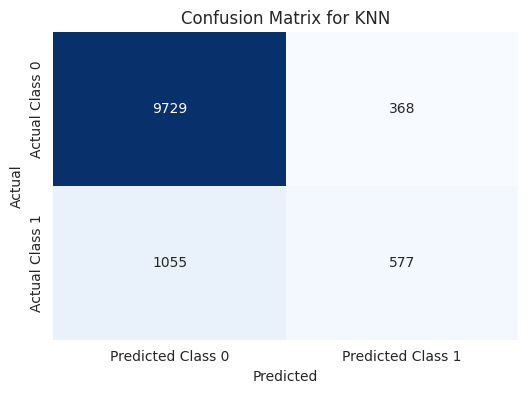

----------------------------------------


----------------------------------------
Support Vector Machine Evaluation Results:
----------------------------------------
Accuracy: 86.09%
R² Score: -0.1616

Confusion Matrix for Support Vector Machine:


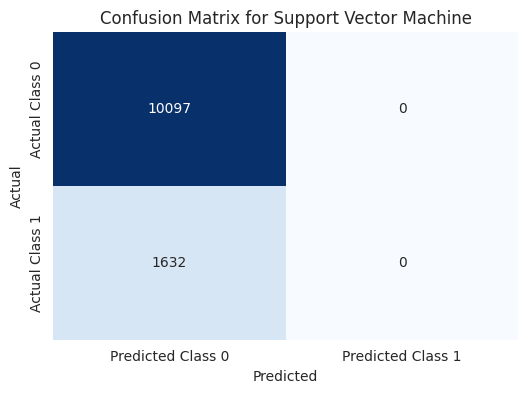

----------------------------------------


----------------------------------------
Decision Tree Evaluation Results:
----------------------------------------
Accuracy: 91.26%
R² Score: 0.2704

Confusion Matrix for Decision Tree:


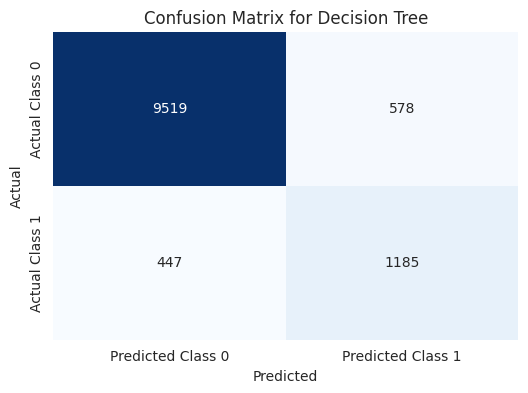

----------------------------------------


----------------------------------------
Neural Network Evaluation Results:
----------------------------------------
Accuracy: 88.88%
R² Score: 0.0718

Confusion Matrix for Neural Network:


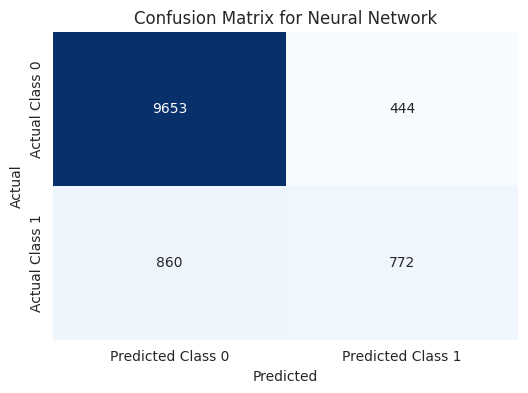

----------------------------------------



In [88]:
from sklearn.metrics import r2_score

# ----------------------------------------------
# Model Training, Evaluation, and Results Collection
# ----------------------------------------------

# Initialize an empty dictionary to store results
results = {}

# Loop through each model for training and evaluation
for model_name, model in models.items():

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "R² Score": r2
    }

# ----------------------------------------------
# Display Model Results
# ----------------------------------------------

# Output results for each model
for model_name, result in results.items():
    print(f"\n{'-'*40}")
    print(f"{model_name} Evaluation Results:")
    print(f"{'-'*40}")

    # Display the accuracy in a more readable format
    print(f"Accuracy: {result['Accuracy']*100:.2f}%")

    # Display the R² Score
    print(f"R² Score: {result['R² Score']:.4f}")

    # Display the confusion matrix with a heatmap
    print(f"\nConfusion Matrix for {model_name}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted Class 0', 'Predicted Class 1'],
                yticklabels=['Actual Class 0', 'Actual Class 1'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"{'-'*40}\n")

Display Results

In [89]:
# Display the results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"R² Score: {result['R² Score']}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])


Random Forest Results:
Accuracy: 0.9509762128058658
R² Score: 0.5907239604269954
Confusion Matrix:
[[10017    80]
 [  495  1137]]

Gradient Boosting Results:
Accuracy: 0.9482479324750618
R² Score: 0.5679468590942369
Confusion Matrix:
[[9989  108]
 [ 499 1133]]

KNN Results:
Accuracy: 0.8786767840395601
R² Score: -0.012869224891105313
Confusion Matrix:
[[9729  368]
 [1055  577]]

Support Vector Machine Results:
Accuracy: 0.8608577031289965
R² Score: -0.16163216797068447
Confusion Matrix:
[[10097     0]
 [ 1632     0]]

Decision Tree Results:
Accuracy: 0.9126097706539347
R² Score: 0.2704209729350787
Confusion Matrix:
[[9519  578]
 [ 447 1185]]

Neural Network Results:
Accuracy: 0.8888225765197374
R² Score: 0.0718331206900904
Confusion Matrix:
[[9653  444]
 [ 860  772]]


Performance Visualization

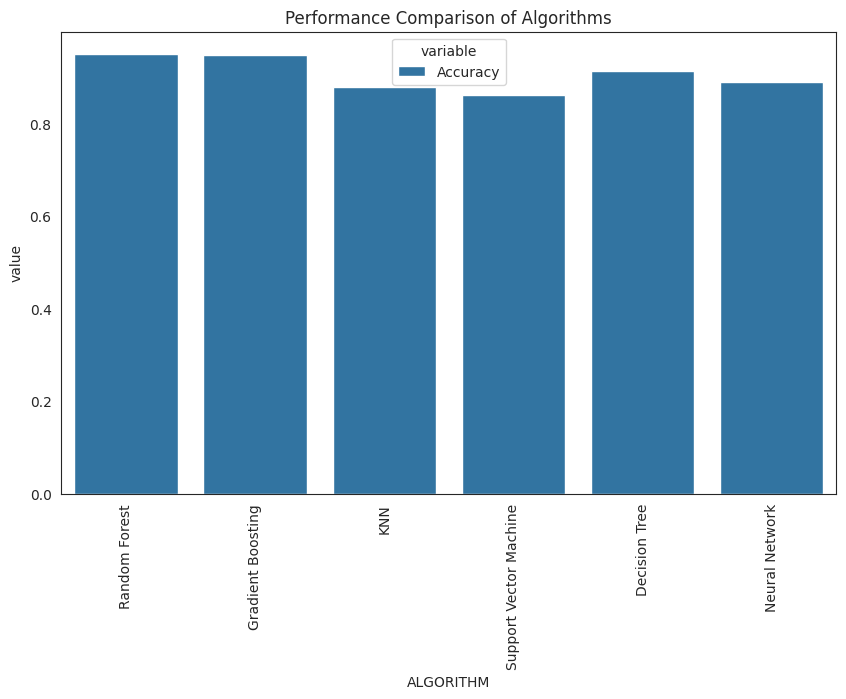

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a list of dictionaries to store the performance data
performance_data = []
for model_name, result in results.items():
    performance_data.append({"ALGORITHM": model_name, "variable": "Accuracy", "value": result['Accuracy']})

# Create a pandas DataFrame from the performance data
performance_df1 = pd.DataFrame(performance_data)

# Create a barplot to compare the performance of all models
plt.figure(figsize=(10, 6))
sns.barplot(x="ALGORITHM", y="value", hue="variable", data=performance_df1)
plt.title("Performance Comparison of Algorithms")
plt.xticks(rotation=90)
plt.show()

Performance Comparison: Visualization

<ipython-input-91-2bcfb252c542>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="value", y="ALGORITHM", data=performance_df, palette="Blues_d")


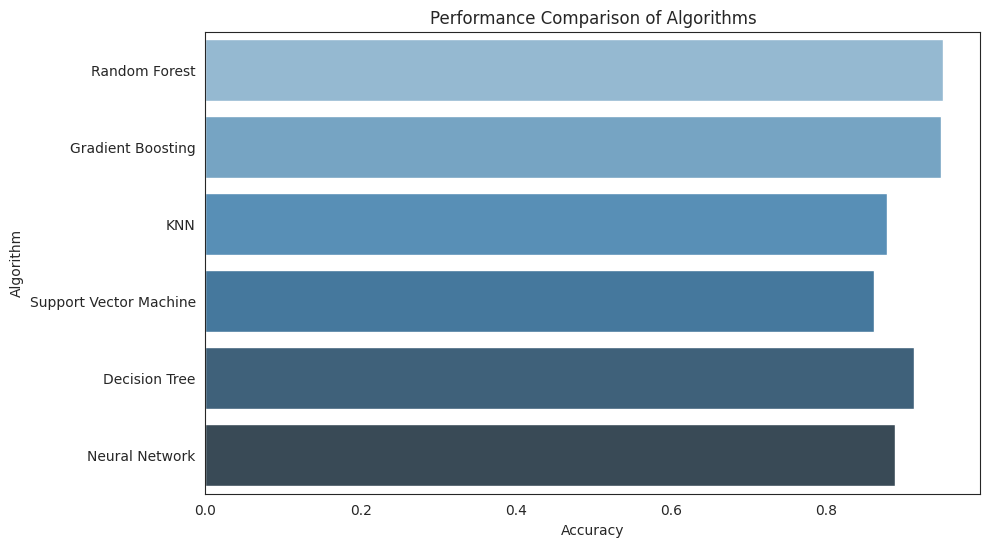

In [91]:
performance_data = []
for model_name, result in results.items():
    performance_data.append({
        "ALGORITHM": model_name,
        "variable": "Accuracy",
        "value": result['Accuracy']
    })

# Convert to DataFrame for plotting
performance_df = pd.DataFrame(performance_data)

# Plot a horizontal bar chart comparing the accuracy of different models
plt.figure(figsize=(10, 6))
sns.barplot(x="value", y="ALGORITHM", data=performance_df, palette="Blues_d")
plt.title("Performance Comparison of Algorithms")
plt.xlabel("Accuracy")
plt.ylabel("Algorithm")
plt.show()

#Best Model Selection Based on Accuracy

In [92]:
# ----------------------------------------------
# Best Model Display with Enhanced Format
# ----------------------------------------------

# Find the best model based on accuracy
best_model = max(results, key=lambda model: results[model]["Accuracy"])

# Display the best model's information in a formatted and readable manner
print("\n===========================================================")
print(f"       🎯 Best Performing Model: {best_model} 🎯")
print("===========================================================")
print(f"\n🔹 Accuracy: {results[best_model]['Accuracy']:.4f}")
print(f"\n🔹 R² Score: {results[best_model]['R² Score']:.4f}")
print(f"\n🔹 Confusion Matrix:")
print(f"\n{results[best_model]['Confusion Matrix']}")
print("\n===========================================================")
print("\n--- End of Best Model Evaluation ---")


       🎯 Best Performing Model: Random Forest 🎯

🔹 Accuracy: 0.9510

🔹 R² Score: 0.5907

🔹 Confusion Matrix:

[[10017    80]
 [  495  1137]]


--- End of Best Model Evaluation ---


Model Saving

In [93]:
# Import necessary library
import pickle

# Define a function to save the best model
def save_best_model(model, filename):
    """
    Save the provided model to a file using pickle.

    Args:
        model: The trained model to be saved.
        filename: The filename where the model will be saved.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"✅ The best model has been successfully saved as '{filename}'.")

# Saving the best model using the new function
save_best_model(results[best_model], 'best_model.pkl')

✅ The best model has been successfully saved as 'best_model.pkl'.


Submission Preview:
      id  loan_status
0  58645            1
1  58646            0
2  58647            0
3  58648            0
4  58649            0


<ipython-input-94-b3406e963160>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=submission, palette='Set2')


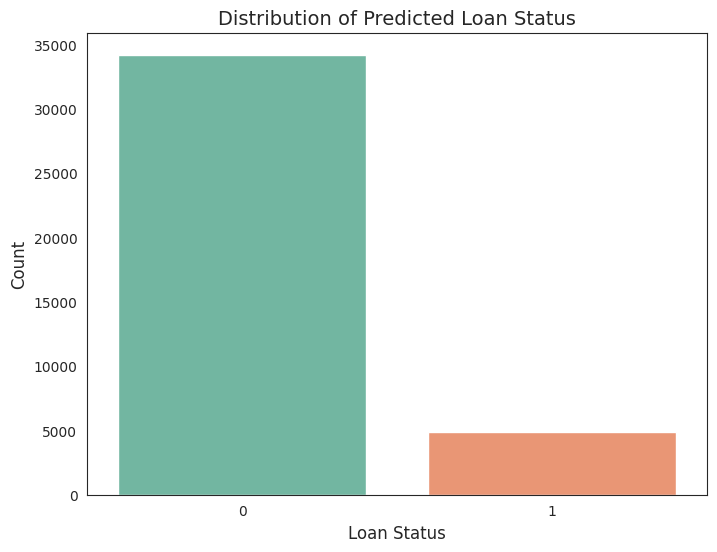

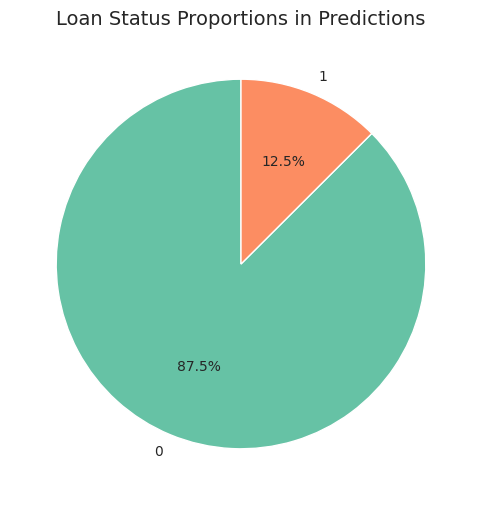


Submission Dataframe:
          id  loan_status
0      58645            1
1      58646            0
2      58647            0
3      58648            0
4      58649            0
...      ...          ...
39093  97738            1
39094  97739            0
39095  97740            0
39096  97741            1
39097  97742            1

[39098 rows x 2 columns]


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'test_df' is the DataFrame with test data and 'y_pred' is the predicted output
test_ids = test_df['id']

# Ensure the test data has the same columns as the training data (features)
# and in the same order
test_data_for_prediction = test_df[features.columns]

# Make predictions
y_pred = model.predict(test_data_for_prediction)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'loan_status': y_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission for confirmation
print("Submission Preview:")
print(submission.head())

# ----------------------------------------------
# Visualization: Loan Status Distribution
# ----------------------------------------------
plt.figure(figsize=(8, 6))

# Plot a count plot to show the distribution of predicted loan statuses
sns.countplot(x='loan_status', data=submission, palette='Set2')

# Adding titles and labels for better understanding
plt.title('Distribution of Predicted Loan Status', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

# ----------------------------------------------
# Pie chart for loan status distribution
# ----------------------------------------------
plt.figure(figsize=(8, 6))

# Pie chart to visualize loan status distribution
loan_status_counts = submission['loan_status'].value_counts()
loan_status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))

# Adding title to the pie chart
plt.title('Loan Status Proportions in Predictions', fontsize=14)

# Display the pie chart
plt.ylabel('')
plt.show()


print("\nSubmission Dataframe:")
print(submission)